In [1]:
%reload_ext watermark
%watermark -v -p numpy,pandas,torch

CPython 3.7.6
IPython 7.13.0

numpy 1.18.1
pandas 1.0.1
torch 1.4.0


In [2]:
import torch

import os, wget
import numpy as np
import pandas as pd
from tqdm import tqdm
import seaborn as sns
from pylab import rcParams
import matplotlib.pyplot as plt
from matplotlib import rc
from sklearn.preprocessing import MinMaxScaler
from pandas.plotting import register_matplotlib_converters
from torch import nn, optim

In [3]:
%matplotlib inline
%config InlineBackend.figure_format='retina'

In [4]:
sns.set(style='whitegrid', palette='muted', font_scale=1.2)

In [5]:
HAPPY_COLORS_PALETTE = ["#01BEFE", "#FFDD00", "#FF7D00", "#FF006D", "#93D30C", "#8F00FF"]

In [6]:
sns.set_palette(sns.color_palette(HAPPY_COLORS_PALETTE))

In [7]:
rcParams['figure.figsize'] = 14, 10
register_matplotlib_converters()

In [8]:
RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)
torch.manual_seed(RANDOM_SEED)

In [9]:
df = pd.read_csv('time_series_19-covid-Confirmed.csv')

In [10]:
df.head()

,Province/State,Country/Region,Lat,Long,1/22/20,1/23/20,1/24/20,1/25/20,1/26/20,1/27/20,...,3/5/20,3/6/20,3/7/20,3/8/20,3/9/20,3/10/20,3/11/20,3/12/20,3/13/20,3/14/20
0,NaN,Thailand,15.0000,101.0000,2,3,5,7,8,8,...,47,48,50,50,50,53,59,70,75,82
1,NaN,Japan,36.0000,138.0000,2,1,2,2,4,4,...,360,420,461,502,511,581,639,639,701,773
2,NaN,Singapore,1.2833,103.8333,0,1,3,3,4,5,...,117,130,138,150,150,160,178,178,200,212
3,NaN,Nepal,28.1667,84.2500,0,0,0,1,1,1,...,1,1,1,1,1,1,1,1,1,1
4,NaN,Malaysia,2.5000,112.5000,0,0,0,3,4,4,...,50,83,93,99,117,129,149,149,197,238


In [11]:
df = df[df['Country/Region'] == 'China']

In [12]:
df = df.iloc[:, 4:]

In [13]:
daily_cases = df.sum(axis=0)
daily_cases.index = pd.to_datetime(daily_cases.index)
daily_cases.head()

2020-01-22     548
2020-01-23     643
2020-01-24     920
2020-01-25    1406
2020-01-26    2075
dtype: int64

Text(0.5, 1.0, 'Cumulative daily cases')

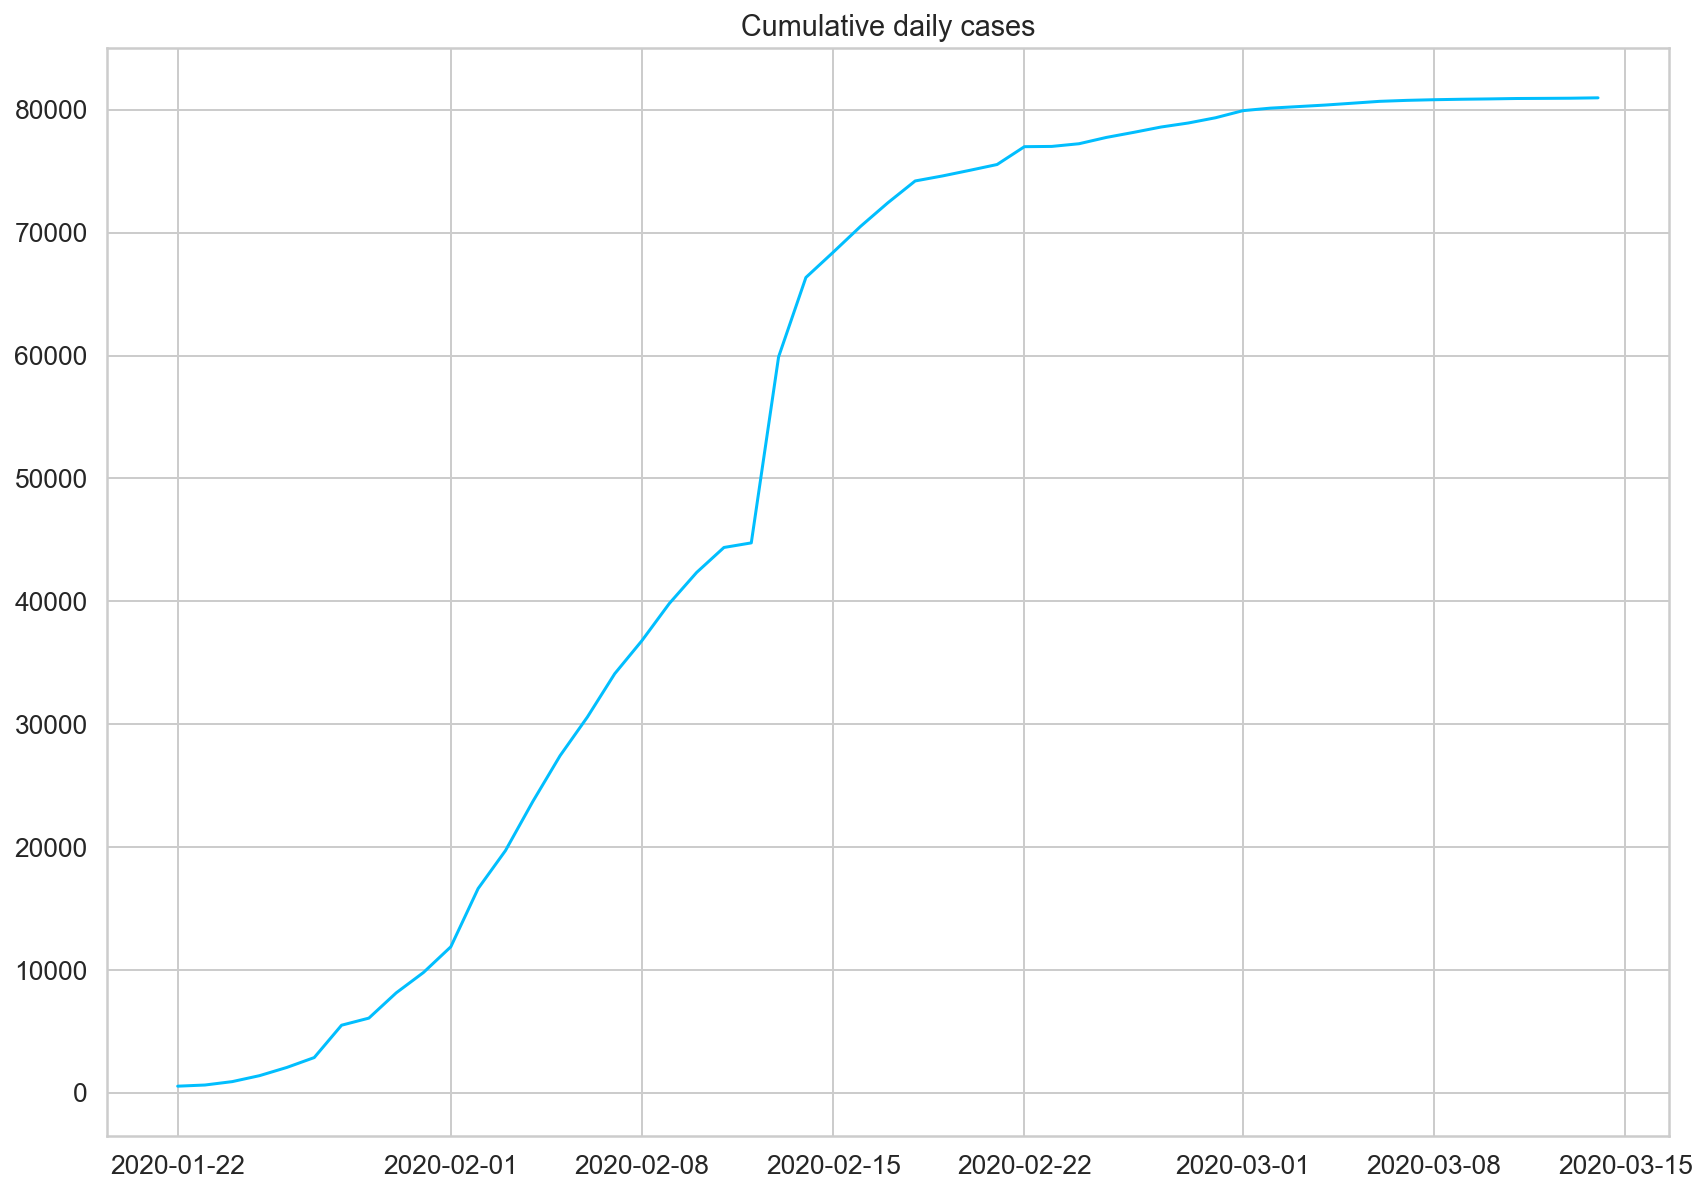

In [14]:
plt.plot(daily_cases)
plt.title("Cumulative daily cases")

In [15]:
cumulative_cases = daily_cases
daily_cases = daily_cases.diff().fillna(daily_cases[0]).astype(np.int64)
daily_cases.head()

2020-01-22    548
2020-01-23     95
2020-01-24    277
2020-01-25    486
2020-01-26    669
dtype: int64

Text(0.5, 1.0, 'Daily cases')

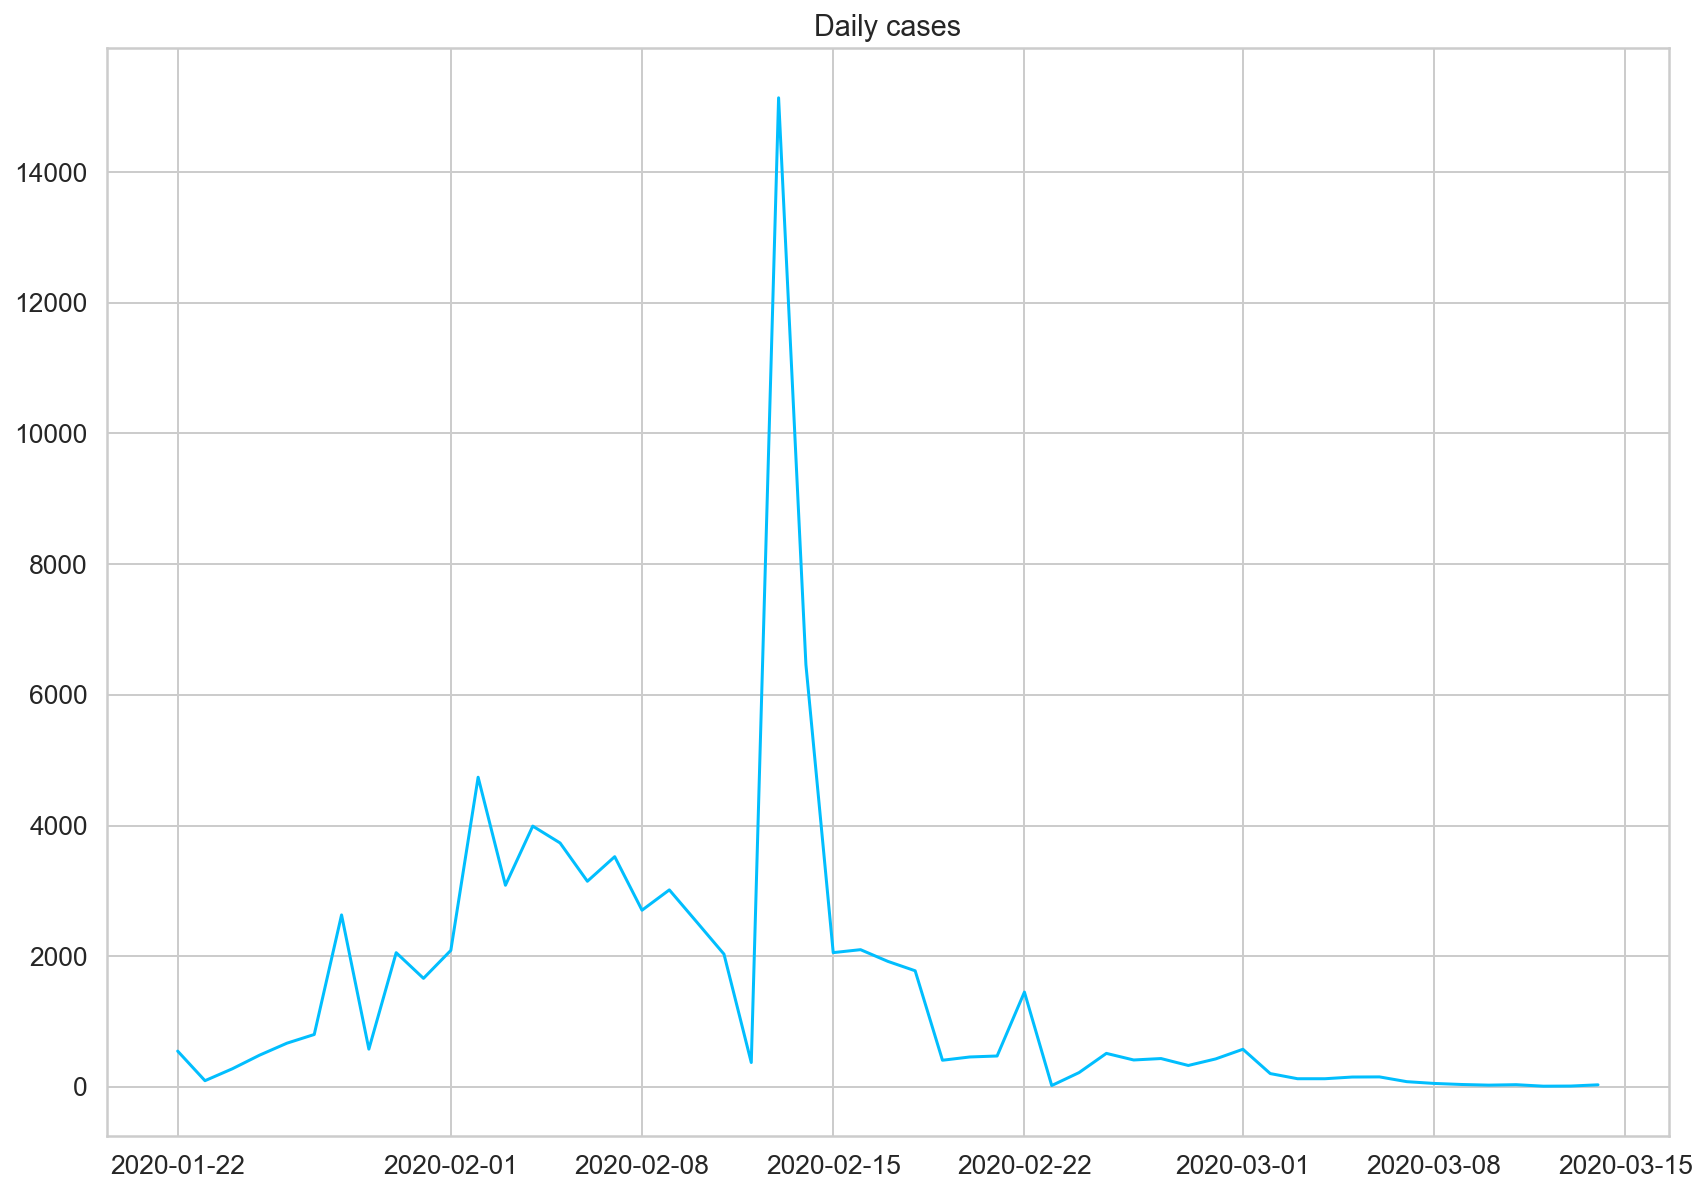

In [16]:
plt.plot(daily_cases)
plt.title("Daily cases")

In [17]:
cumulative_cases.shape

(53,)

In [18]:
test_data_size = 7

train_data = cumulative_cases[:-test_data_size]
test_data = cumulative_cases[-test_data_size:]

train_data.shape

(46,)

In [19]:
scaler = MinMaxScaler()

scaler = scaler.fit(np.expand_dims(train_data, axis=1))

train_data = scaler.transform(np.expand_dims(train_data, axis=1))

test_data = scaler.transform(np.expand_dims(test_data, axis=1))

In [20]:
def create_sequences(data, seq_length):
    xs = []
    ys = []

    for i in range(len(data)-seq_length-1):
        x = data[i:(i+seq_length)]
        y = data[i+seq_length]
        xs.append(x)
        ys.append(y)

    return np.array(xs), np.array(ys)

In [21]:
seq_length = 3
X_train, y_train = create_sequences(train_data, seq_length)
X_test, y_test = create_sequences(test_data, seq_length)

X_train = torch.from_numpy(X_train).float()
y_train = torch.from_numpy(y_train).float()

X_test = torch.from_numpy(X_test).float()
y_test = torch.from_numpy(y_test).float()

In [22]:
X_train.shape

torch.Size([42, 3, 1])

In [23]:
X_train[:2]

tensor([[[0.0000],
         [0.0012],
         [0.0046]],

        [[0.0012],
         [0.0046],
         [0.0107]]])

In [24]:
y_train.shape

torch.Size([42, 1])

In [25]:
class CoronaVirusPredictor(nn.Module):

  def __init__(self, n_features, n_hidden, seq_len, n_layers=2):
    super(CoronaVirusPredictor, self).__init__()

    self.n_hidden = n_hidden
    self.seq_len = seq_len
    self.n_layers = n_layers

    self.lstm = nn.LSTM(
      input_size=n_features,
      hidden_size=n_hidden,
      num_layers=n_layers,
      dropout=0.6
    )

    self.linear = nn.Linear(in_features=n_hidden, out_features=1)

  def reset_hidden_state(self):
    self.hidden = (
        torch.zeros(self.n_layers, self.seq_len, self.n_hidden),
        torch.zeros(self.n_layers, self.seq_len, self.n_hidden)
    )

  def forward(self, sequences):
    lstm_out, self.hidden = self.lstm(
      sequences.view(len(sequences), self.seq_len, -1),
      self.hidden
    )
    last_time_step = \
      lstm_out.view(self.seq_len, len(sequences), self.n_hidden)[-1]
    y_pred = self.linear(last_time_step)
    return y_pred

In [26]:
def train_model(model, train_data, train_labels, test_data=None,test_labels=None):
    
  loss_fn = torch.nn.MSELoss(reduction='sum')

  optimiser = torch.optim.Adam(model.parameters(), lr=1e-4, weight_decay=0.1)
  num_epochs = 150

  train_hist = np.zeros(num_epochs)
  test_hist = np.zeros(num_epochs)

  for t in range(num_epochs):
    model.reset_hidden_state()

    y_pred = model(X_train)

    loss = loss_fn(y_pred.float(), y_train)

    if test_data is not None:
      with torch.no_grad():
        y_test_pred = model(X_test)
        test_loss = loss_fn(y_test_pred.float(), y_test)
      test_hist[t] = test_loss.item()

      if t % 10 == 0:
        print(f'Epoch {t} train loss: {loss.item()} test loss: {test_loss.item()}')
    elif t % 10 == 0:
      print(f'Epoch {t} train loss: {loss.item()}')

    train_hist[t] = loss.item()

    optimiser.zero_grad()

    loss.backward()

    optimiser.step()

  return model.eval(), train_hist, test_hist

In [27]:
model = CoronaVirusPredictor(
  n_features=1,
  n_hidden=512,
  seq_len=seq_length,
  n_layers=2
)
model, train_hist, test_hist = train_model(
  model,
  X_train,
  y_train,
  X_test,
  y_test
)

Epoch 0 train loss: 21.513044357299805 test loss: 2.926558017730713
Epoch 10 train loss: 14.71311092376709 test loss: 2.0842092037200928
Epoch 20 train loss: 7.407225131988525 test loss: 1.0346708297729492
Epoch 30 train loss: 5.946836948394775 test loss: 0.09704028069972992
Epoch 40 train loss: 5.42809534072876 test loss: 0.4950917661190033
Epoch 50 train loss: 5.474021911621094 test loss: 0.44772154092788696
Epoch 60 train loss: 5.272286891937256 test loss: 0.32148903608322144
Epoch 70 train loss: 5.094748020172119 test loss: 0.3760837912559509
Epoch 80 train loss: 5.154694080352783 test loss: 0.35419219732284546
Epoch 90 train loss: 5.231882572174072 test loss: 0.33657360076904297
Epoch 100 train loss: 5.138448715209961 test loss: 0.3705415725708008
Epoch 110 train loss: 5.0339250564575195 test loss: 0.3143446445465088
Epoch 120 train loss: 5.098948955535889 test loss: 0.3017423748970032
Epoch 130 train loss: 4.7456817626953125 test loss: 0.2959069311618805
Epoch 140 train loss: 4.3

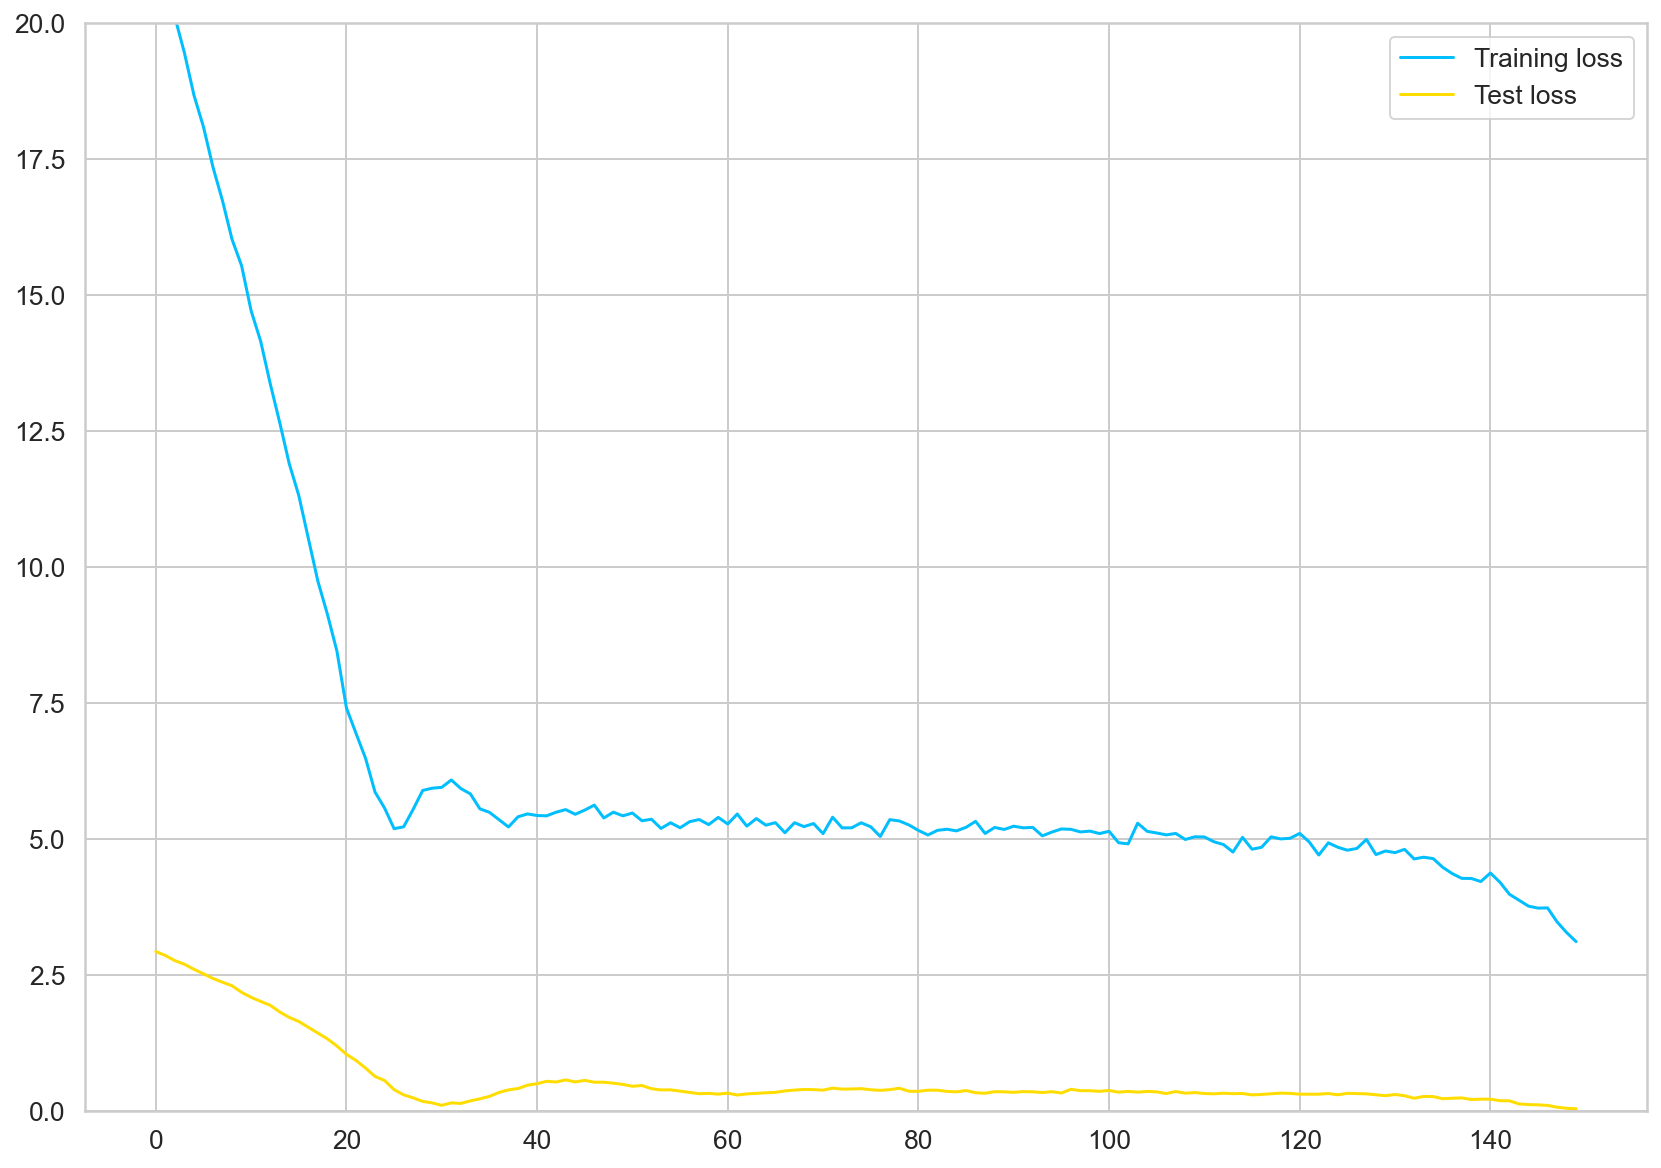

In [28]:
plt.plot(train_hist, label="Training loss")
plt.plot(test_hist, label="Test loss")
plt.ylim((0, 20))
plt.legend()

In [33]:
with torch.no_grad():
    test_seq = X_test[:1]
    print(test_seq)
    preds = []
    for _ in range(len(X_test)):
        y_test_pred = model(test_seq)
        pred = torch.flatten(y_test_pred).item()
        preds.append(pred)
        new_seq = test_seq.numpy().flatten()
        new_seq = np.append(new_seq, [pred])
        new_seq = new_seq[1:]
        test_seq = torch.as_tensor(new_seq).view(1, seq_length, 1).float()
        print(test_seq)

tensor([[[1.0007],
         [1.0011],
         [1.0015]]])
tensor([[[1.0011],
         [1.0015],
         [1.0047]]])
tensor([[[1.0015],
         [1.0047],
         [1.0229]]])
tensor([[[1.0047],
         [1.0229],
         [1.0413]]])


In [34]:
true_cases = scaler.inverse_transform(
    np.expand_dims(y_test.flatten().numpy(), axis=0)
).flatten()

predicted_cases = scaler.inverse_transform(
  np.expand_dims(preds, axis=0)
).flatten()

In [35]:
true_cases

array([80921., 80932., 80945.], dtype=float32)

In [36]:
predicted_cases

array([81143.28068328, 82603.87894726, 84081.42321515])

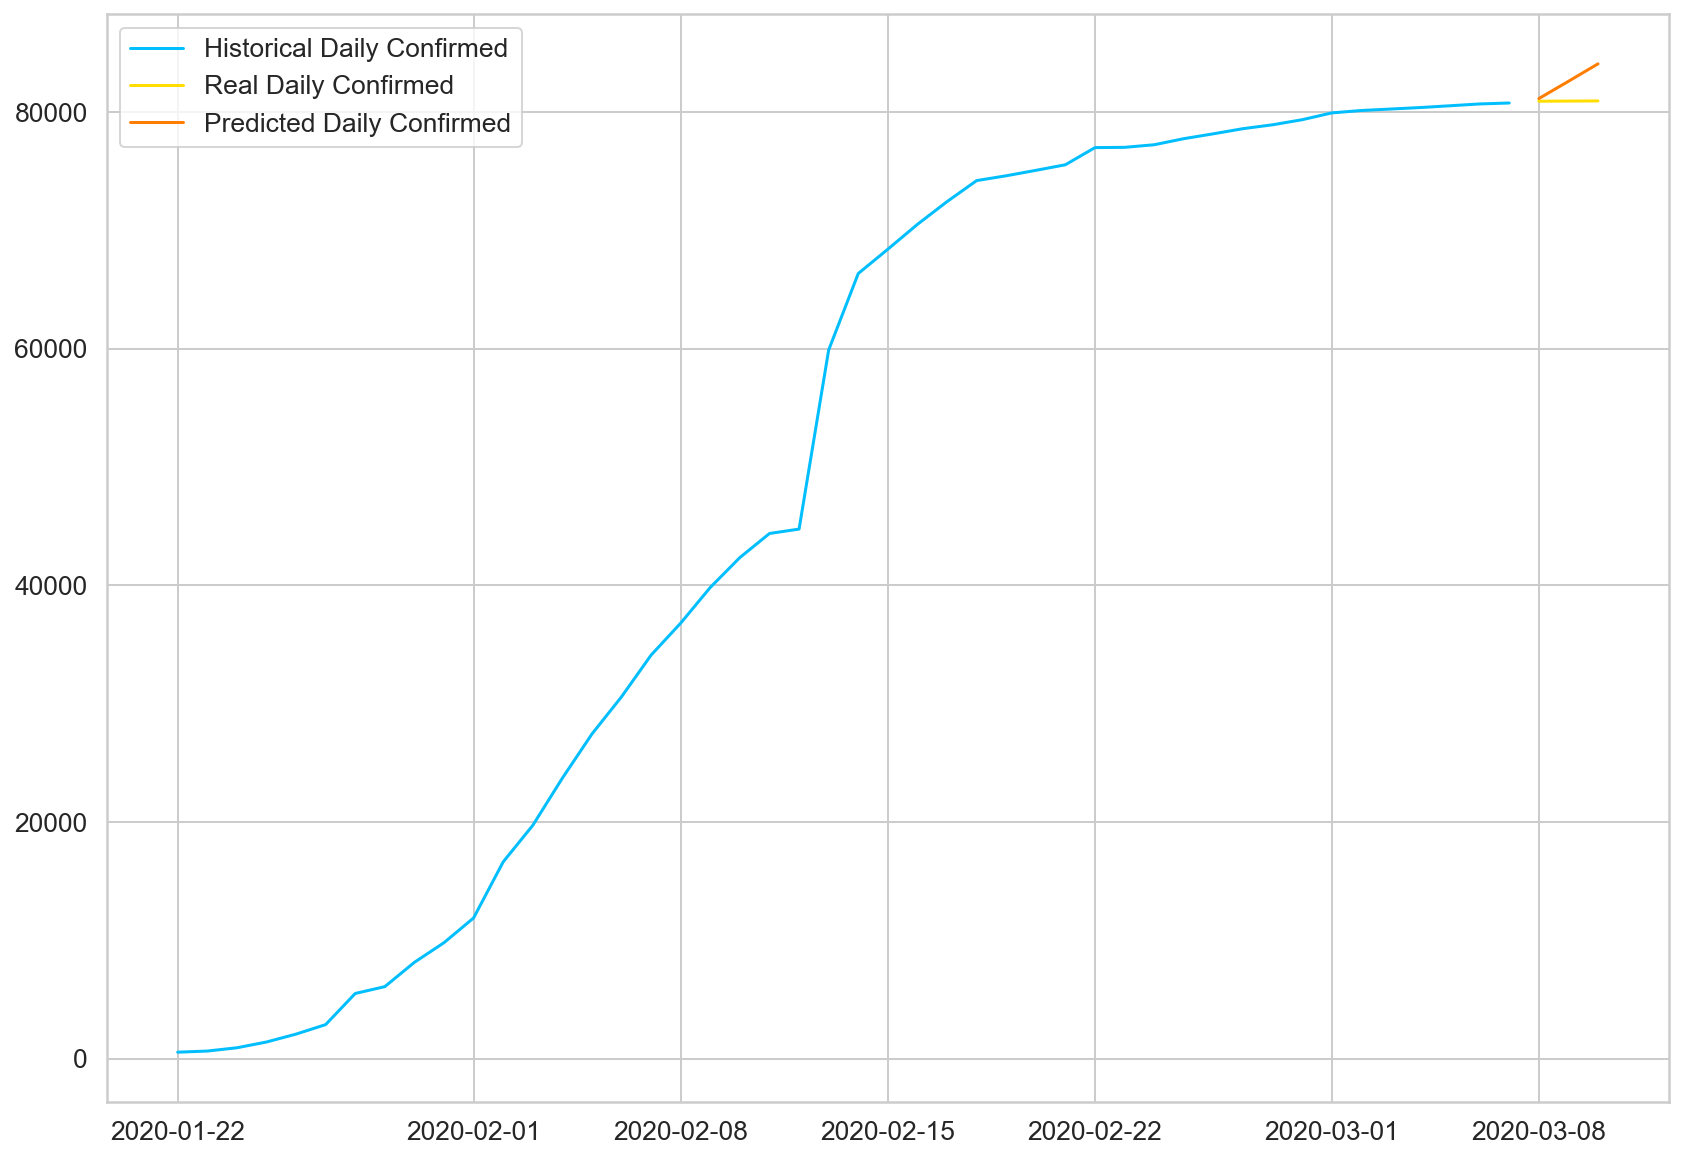

In [37]:
plt.plot(
  cumulative_cases.index[:len(train_data)],
  scaler.inverse_transform(train_data).flatten(),
  label='Historical Daily Confirmed'
)

plt.plot(
  cumulative_cases.index[len(train_data):len(train_data) + len(true_cases)],
  true_cases,
  label='Real Daily Confirmed'
)

plt.plot(
  cumulative_cases.index[len(train_data):len(train_data) + len(true_cases)],
  predicted_cases,
  label='Predicted Daily Confirmed'
)

plt.legend()